# Loading Test Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# My Google Drive was mounted for this notebook; therefore these links are relative to my drive only
MASTER_PATH = "/content/drive/MyDrive/Public Datasets/VIDEO DATA - ACTIVITY WISE/"

In [3]:
# Frequency of recording the data
FREQ = 50  # No. of frames per second

In [4]:
# Read the CSV file corresponding to each label into a dataframe and then obtain the final dataframe (df) by concatenating them

# List of the labels as in the names of the files
lnames = ["E", "D", "W", "S", "L", "RS", "RL", "G", "I"]
# Initialize as an empty dataframe
df = pd.DataFrame()
# Concatenate to collect all the data into the single dataframe
for i in range(1, 10):
    # CSV file's location
    url = MASTER_PATH + str(i) + lnames[i - 1] + "_label.csv"
    tempdf = pd.read_csv(url)
    # Concatenate into the existing dataframe
    df = pd.concat([df, tempdf], ignore_index = True)

# Review the obtained dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978321 entries, 0 to 4978320
Data columns (total 11 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    int64  
 1   acc_x   float64
 2   acc_y   float64
 3   acc_z   float64
 4   gyr_x   float64
 5   gyr_y   float64
 6   gyr_z   float64
 7   mag_x   float64
 8   mag_y   float64
 9   mag_z   float64
 10  label   int64  
dtypes: float64(9), int64(2)
memory usage: 417.8 MB


# Preprocessing Data for Testing

In [5]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

In [6]:
# The function which returns the processed form of the data
def process(data):
    # Names of the necessary columns
    columns = data.columns[1 : -1]
    # Standardize the independent variables' data
    scaler = StandardScaler()
    tempx = data[columns].copy().values
    processeddf = pd.DataFrame(scaler.fit_transform(tempx), columns = columns)
    # Subtract one from the labels for matching with the trained model
    tempy = data["label"].copy().values - 1
    processeddf["label"] = tempy

    # Return the processed data
    return processeddf

In [7]:
# Obtain the processed dataset
processeddf = process(df)
# Review
processeddf.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,label
0,-0.749737,0.480876,-0.040893,1.042128,-0.859440,1.805667,0.202621,0.764388,-1.390699,0
1,-1.420490,0.718053,-0.612779,-2.197140,1.526360,-0.457083,0.250092,0.775345,-1.363310,0
2,-1.355739,0.683045,-0.253949,-1.230447,-0.235591,-0.753482,0.269080,0.786302,-1.387275,0
3,-1.136583,0.558768,0.015174,-0.212876,-0.079629,-0.377562,0.226356,0.783562,-1.387275,0
4,-0.905804,0.498379,-0.085747,0.358094,-0.416845,0.034505,0.245345,0.791780,-1.407817,0


In [8]:
# The function which returns 4s windows from the given data
def getWindows(data):  # data corresponds to processed data
    winsize = FREQ * 4  # 4s corresponds to this number of frames/entries
    skip = FREQ * 2  # # Consecutive windows should overlap with a difference of 2s between their initial frames
    windows = []
    labels = []
    # Number of entries in the dataset
    n = len(data)
    # The feature set and the label set
    X = data[data.columns[: -1]].copy().values
    y = data["label"].copy().values

    for i in range(0, n - winsize, skip):
        windows.append(X[i : i + winsize])
        labels.append(mode(y[i : i + winsize])[0][0])
    # Reshape windows into 4D to make it compatible with the model
    windows = np.array(windows)
    windows = windows.reshape(*windows.shape, 1)
    labels = np.array(labels)
    # Return the windows and the labels (the future X and y)
    return windows, labels

In [9]:
# Obtain the test set
testX, testy = getWindows(processeddf)
# Check their shapes
testX.shape, testy.shape

((49782, 200, 9, 1), (49782,))

# Loading the Model

In [10]:
from tensorflow.keras.models import load_model

In [11]:
# Path to the model saved during training
MODEL_PATH = "cow-activity-model"

In [12]:
# Load the model
model = load_model(MODEL_PATH)

# Testing and Evaluating the Model

In [13]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [14]:
# Function to return the list of predictions (yhat)
def predict(X):
    yprobs = model.predict(X)  # Probabilities of a datapoint corresponding to a label
    yhat = np.argmax(yprobs, axis = 1)  # Indices of the labels corresponding to the maximum probabilities
    return yhat

In [15]:
# Predict
yhat = predict(testX)

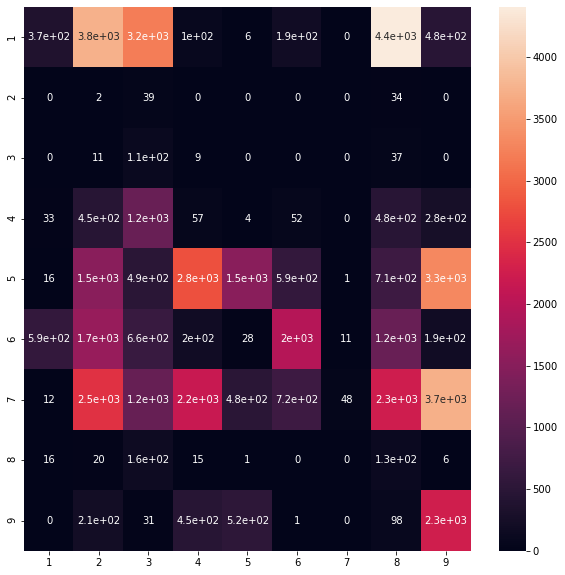

In [16]:
# Obtain the confusion matrix
cmat = confusion_matrix(testy, yhat)
# Plot the confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(cmat, xticklabels = range(1, 10), yticklabels = range(1, 10), annot = True)

In [17]:
# Check the accuracy of the model
accuracy_score(testy, yhat)

0.1302880559238279